In [8]:
# Library
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan

import warnings
warnings.simplefilter('ignore')
import seaborn as sns

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None

---
## Data
Quarterly (1982Q1-2024Q3)
### Output gap
Beveridge-Nelson Filter's cycle component (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### The number of Firm
Business Employment Dynamics (https://db.nomics.world/BLS/bd?tab=list)

---

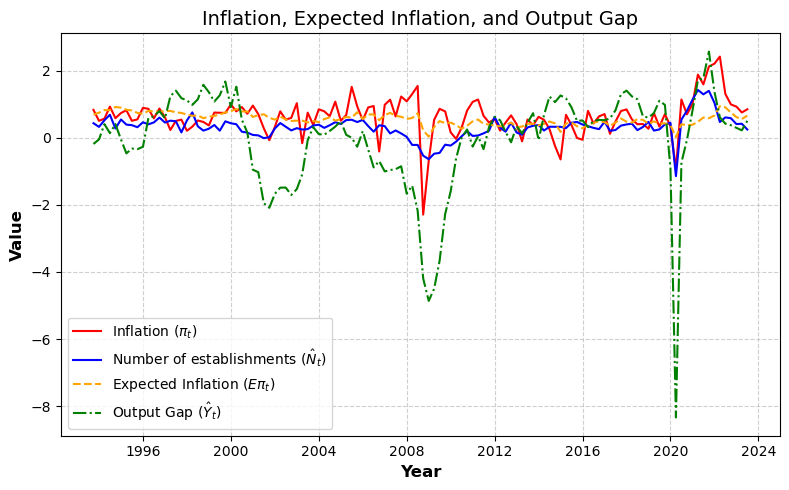

In [9]:
# Data cleaning and plot
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_N = pd.merge(data_Nb, data_Nd, on = "DATE")
data_N = data_N.dropna()
data_N["Nchange"] = data_N["Nb"] - data_N["Nd"]
initial_value = 6411440
data_N["N_stock"] = initial_value + data_N["Nchange"].cumsum()
data_N["N_stock_prev"] = data_N["N_stock"].shift(1)
data_N["N"] = (np.log(data_N["N_stock"]) - np.log(data_N["N_stock"].shift(1))) * 100
data_N["N_prev"] = data_N["N"].shift(1)
data_N = data_N.dropna(inplace=False)

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])
data_N['DATE'] = pd.to_datetime(data_N['DATE'])

data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")

data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data = data.dropna()
data = data[["DATE","pi", "Epi", "Y", "N", "N_prev", "pi_prev", "Y_prev"]]

# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
Y = jnp.array(data['Y'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Y_prev = jnp.array(data['Y_prev'],dtype=jnp.float64)
n_prev = jnp.array(data['N_prev'],dtype=jnp.float64)

# plot
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')
plt.plot(data["DATE"], data["N"], label=r'Number of establishments $(\hat{N}_{t})$', linestyle='-', color='blue')        
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [10]:
warmup= 5000
samples=25000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

# Model
- $\alpha$ + $\beta$ = 1
- Model 1 : NKPC 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

- Model 2 : HSA NKPC without N:
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}}+ \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

- Model 3 : HSA NKPC with N:
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}} +  \theta_N \hat{N}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

- Model 4 : HSA NKPC without N (time variant kappa):
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa_{t} \hat{Y}_t - \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} =  \rho_{\kappa} \kappa_{{t-1}} + \rho_{z} z_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$

- Model 5 : HSA NKPC with N (time variant kappa):
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa_{t} \hat{Y}_t - \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}} +  \theta_N \hat{N}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{\kappa} \kappa_{{t-1}} + \rho_{z} z_{{t-1}} + \rho_{N} N_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$

- Model 6 : NKPC (time variant kappa)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$\kappa_{{t}} = \rho_{\kappa} \kappa_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$

In [11]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "beta"       : dist.Beta(0.5, 0.1),
        "kappa"      : dist.Normal(0, 0.2),
        # State equation (z) params
        "theta_z"    : dist.Beta(0.5, 0.1),
        "theta_pi"   : dist.Beta(0.5, 0.1),
        "theta_n"    : dist.Normal(0, 0.2),
        "theta_Y"    : dist.Normal(0, 0.2),
        # State equation (kappa) params
        "rho_k"      : dist.Beta(0.5, 0.1),
        "rho_z"      : dist.Normal(0, 0.2),
        # initial
        "z_init"     : dist.Normal(0, 0.2),
        "kappa_init" : dist.Normal(0, 0.2),
        # Sigma
        "sigma_eps"  : dist.HalfNormal(0.2),
        "sigma_kappa": dist.HalfNormal(0.2),
        "sigma_eta"  : dist.HalfNormal(0.2),
    }
    return priors
        

In [12]:
# Model 1
def model_1(pi, pi_prev, pi_expect, Y):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    # model
    pi_pred = alpha * pi_prev + beta * pi_expect + kappa * Y
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi)

# RUN MCMC
kernel = NUTS(model_1, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_1_kappa = posterior_samples["kappa"].mean()
model_1_alpha = posterior_samples["alpha"].mean()
model_1_beta = posterior_samples["beta"].mean()
diverging  = idata_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")                  # bool for each param

sample: 100%|██████████| 30000/30000 [00:05<00:00, 5168.37it/s, 47 steps of size 3.60e-02. acc. prob=1.00] 


divergence ratio = 0.0000%


In [13]:
# Model 2
def model_2(pi, pi_prev, pi_expect, Y, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # State equation (z) params
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        t = carry[1]
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        z_carry = z
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        return [z_carry, t_carry], None
    scan(transition, [z_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,
          l=len(pi))
idata_2 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std_2 = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.97 * z_std_2     
z_upper_2 = z_mean_2 + 1.97 * z_std_2  

model_2_alpha = posterior_samples["alpha"].mean()
model_2_kappa = posterior_samples["kappa"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_theta_z = posterior_samples["theta_z"].mean()
model_2_theta_Y = posterior_samples["theta_Y"].mean()
model_2_theta_pi = posterior_samples["theta_pi"].mean()
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 30000/30000 [02:49<00:00, 176.49it/s, 1023 steps of size 8.21e-05. acc. prob=1.00]


divergence ratio = 0.0000%


In [14]:
# Model 3
def model_3(pi, pi_prev, pi_expect, Y, Y_prev, n_prev, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # State equation (z) params
    theta_n = numpyro.sample("theta_n", priors["theta_n"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        t = carry[1]
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_n * n_prev[t] + theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        z_carry = z
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        return [z_carry, t_carry], None
    scan(transition, [z_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_3, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,n_prev=n_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std_3 = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.97 * z_std_3     
z_upper_3 = z_mean_3 + 1.97 * z_std_3  

model_3_alpha = posterior_samples["alpha"].mean()
model_3_kappa = posterior_samples["kappa"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_theta_z = posterior_samples["theta_z"].mean()
model_3_theta_Y = posterior_samples["theta_Y"].mean()
model_3_theta_pi = posterior_samples["theta_pi"].mean()
model_3_theta_n = posterior_samples["theta_n"].mean()
diverging  = idata_3.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 30000/30000 [03:25<00:00, 145.95it/s, 1023 steps of size 9.92e-05. acc. prob=0.99]


divergence ratio = 0.0000%


In [15]:
# Model 4
def model_4(pi, pi_prev, pi_expect, Y, Y_prev, l):
    priors = set_prior_distributions()
    beta   = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa_init = numpyro.sample("kappa_init", priors["kappa"])
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state equation params
    rho_z = numpyro.sample("rho_z", priors["rho_z"])
    rho_k = numpyro.sample("rho_k", priors["rho_k"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_Y     = numpyro.sample("theta_Y",     priors["theta_Y"])
    theta_pi    = numpyro.sample("theta_pi",  priors["theta_pi"])
    # sigma
    sigma_eta   = numpyro.sample("sigma_eta",   priors["sigma_eta"])
    sigma_eps   = numpyro.sample("sigma_e",     priors["sigma_eps"])
    sigma_kappa = numpyro.sample("sigma_kappa", priors["sigma_kappa"])
    timesteps = jnp.arange(l)
    t = 0
    # state space model
    def transition(carry, _):
        # t-1
        z_prev = carry[0]
        kappa_prev = carry[1]
        t = carry[2]
        kappa = numpyro.sample("kappa", numpyro.distributions.TruncatedNormal(rho_k * kappa_prev + rho_z * z_prev, sigma_kappa, low=0))
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_z * z_prev + theta_Y * Y_prev[t] + theta_pi * pi_prev[t], sigma_eta))
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        z_carry = z
        kappa_carry = kappa
        return [z_carry, kappa_carry, t_carry], None
    scan(transition, [z_init, kappa_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_4, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_4 = np.mean(z_samples, axis=0) 
z_std_4 = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.97 * z_std_4     
z_upper_4 = z_mean_4 + 1.97 * z_std_4  

kappa_samples = posterior_samples["kappa"]
kappa_mean_4 = np.mean(kappa_samples, axis=0) 
kappa_std_4 = np.std(kappa_samples, axis=0)  
kappa_lower_4 = kappa_mean_4 - 1.97 * kappa_std_4     
kappa_upper_4 = kappa_mean_4 + 1.97 * kappa_std_4  

model_4_alpha = posterior_samples["alpha"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_theta_z = posterior_samples["theta_z"].mean()
model_4_rho_z = posterior_samples["rho_z"].mean()
model_4_rho_k = posterior_samples["rho_k"].mean()
model_4_theta_Y = posterior_samples["theta_Y"].mean()
model_4_theta_pi = posterior_samples["theta_pi"].mean()
diverging  = idata_4.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 30000/30000 [06:36<00:00, 75.68it/s, 1023 steps of size 4.35e-05. acc. prob=1.00]


divergence ratio = 0.0000%


In [16]:
# Model 5
def model_5(pi, pi_prev, pi_expect, Y, Y_prev, n_prev, l):
    priors = set_prior_distributions()
    beta   = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa_init = numpyro.sample("kappa_init", priors["kappa"])
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state equation params
    rho_z = numpyro.sample("rho_z", priors["rho_z"])
    rho_k = numpyro.sample("rho_k", priors["rho_k"])
    rho_n = numpyro.sample("rho_n", dist.Normal(0, 0.2))
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_Y     = numpyro.sample("theta_Y",     priors["theta_Y"])
    theta_pi    = numpyro.sample("theta_pi",  priors["theta_pi"])
    theta_n    = numpyro.sample("theta_n",  priors["theta_n"])
    # sigma
    sigma_eta   = numpyro.sample("sigma_eta",   priors["sigma_eta"])
    sigma_eps   = numpyro.sample("sigma_e",     priors["sigma_eps"])
    sigma_kappa = numpyro.sample("sigma_kappa", priors["sigma_kappa"])
    timesteps = jnp.arange(l)
    t = 0
    # state space model
    def transition(carry, _):
        # t-1
        z_prev = carry[0]
        kappa_prev = carry[1]
        t = carry[2]
        kappa = numpyro.sample("kappa", numpyro.distributions.TruncatedNormal(rho_k * kappa_prev + rho_z * z_prev + rho_n * n_prev[t], sigma_kappa, low=0))
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_n * n_prev[t] + theta_z * z_prev + theta_Y * Y_prev[t] + theta_pi * pi_prev[t], sigma_eta))
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        z_carry = z
        kappa_carry = kappa
        return [z_carry, kappa_carry, t_carry], None
    scan(transition, [z_init, kappa_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_5, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,n_prev=n_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_samples, axis=0) 
z_std_5 = np.std(z_samples, axis=0)  
z_lower_5 = z_mean_5 - 1.97 * z_std_5     
z_upper_5 = z_mean_5 + 1.97 * z_std_5  

kappa_samples = posterior_samples["kappa"]
kappa_mean_5 = np.mean(kappa_samples, axis=0) 
kappa_std_5 = np.std(kappa_samples, axis=0)  
kappa_lower_5 = kappa_mean_5 - 1.97 * kappa_std_5     
kappa_upper_5 = kappa_mean_5 + 1.97 * kappa_std_5  

model_5_alpha = posterior_samples["alpha"].mean()
model_5_beta = posterior_samples["beta"].mean()
model_5_theta_z = posterior_samples["theta_z"].mean()
model_5_rho_z = posterior_samples["rho_z"].mean()
model_5_rho_k = posterior_samples["rho_k"].mean()
model_5_theta_Y = posterior_samples["theta_Y"].mean()
model_5_theta_pi = posterior_samples["theta_pi"].mean()
model_5_theta_n = posterior_samples["theta_n"].mean()

diverging  = idata_5.sample_stats["diverging"].values
ratio_div  = diverging.mean()         
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 30000/30000 [06:57<00:00, 71.77it/s, 1023 steps of size 3.32e-03. acc. prob=0.99]


divergence ratio = 0.0000%


In [17]:
# Model 6
def model_6(pi, pi_prev, pi_expect, Y, l):
    priors = set_prior_distributions()
    beta   = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa_init = numpyro.sample("kappa_init", priors["kappa"])
    # state equation params
    rho_k = numpyro.sample("rho_k", priors["rho_k"])
    # sigma
    sigma_eps   = numpyro.sample("sigma_e",     priors["sigma_eps"])
    sigma_kappa = numpyro.sample("sigma_kappa", priors["sigma_kappa"])
    timesteps = jnp.arange(l)
    t = 0
    # state space model
    def transition(carry, _):
        # t-1
        kappa_prev = carry[0]
        t = carry[1]
        kappa = numpyro.sample("kappa", numpyro.distributions.TruncatedNormal(rho_k * kappa_prev, sigma_kappa, low=0))
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t]
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        kappa_carry = kappa
        return [kappa_carry, t_carry], None
    scan(transition, [kappa_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_6, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_6 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()

kappa_samples = posterior_samples["kappa"]
kappa_mean_6 = np.mean(kappa_samples, axis=0) 
kappa_std_6 = np.std(kappa_samples, axis=0)  
kappa_lower_6 = kappa_mean_6 - 1.97 * kappa_std_6     
kappa_upper_6 = kappa_mean_6 + 1.97 * kappa_std_6  

model_6_alpha = posterior_samples["alpha"].mean()
model_6_beta = posterior_samples["beta"].mean()
model_6_rho_k = posterior_samples["rho_k"].mean()
diverging  = idata_6.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 30000/30000 [01:07<00:00, 443.22it/s, 255 steps of size 1.76e-02. acc. prob=0.99]


divergence ratio = 0.1040%


## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

,model,alpha,beta,kappa,theta_z,theta_Y,theta_pi,theta_n,rho_k,rho_z,rho_n,sigma_eps,sigma_kappa,sigma_eta
0,Normal NKPC,0.164,0.836,0.089,-,-,-,-,-,-,-,0.473,-,-
1,Normal NKPC: time-variant,0.145,0.855,-,-,-,-,-,0.532,-,-,-,0.134,-
2,HSA NKPC without N,0.000,1.000,0.178,0.699,0.044,0.003,-,-,-,-,0.340,-,0.246
3,HSA NKPC with N,0.000,1.000,0.135,1.000,0.073,0.262,-0.452,-,-,-,0.300,-,0.198
4,HSA NKPC wihout N time-variant,0.010,0.990,-,0.905,0.017,0.009,-,0.072,-0.275,-,-,0.152,0.167
5,HSA NKPC with N time-variant,0.008,0.992,-,0.781,0.032,0.080,-0.186,0.127,-0.083,-0.005,-,0.205,0.234


,elpd_waic,p_waic
HSA NKPC with N time-variant,14.256532,383.278381
HSA NKPC wihout N time-variant,-18.918447,31.707829
HSA NKPC with N,-22.291571,11.071979
HSA NKPC without N,-55.639111,25.450848
Normal NKPC: time-variant,-78.044142,22.962601
Normal NKPC,-89.361695,11.712208


,Variable,Variance
0,π,0.3208271
1,Ŷ,2.1189752
2,N,0.1134076
3,E[πₜ₊₁],0.032140866


,Model,Variance of Z
0,Model 2,0.106976874
1,Model 3,0.12799579
2,Model 4,0.09482329
3,Model 5,0.12225682


,Variable,Correlation
0,"Cov(N, Y)",0.748761


,Model,"Cov(z, Y)"
0,Model 2,0.339190
1,Model 3,0.175323
2,Model 4,0.353337
3,Model 5,0.425981


,Model,"Cov(z, N)"
0,Model 2,0.011990
1,Model 3,-0.156716
2,Model 4,0.016538
3,Model 5,0.072183


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
HSA NKPC with N time-variant,0,5.548113,400.308980,0.000000,7.334821e-01,16.084111,0.000000,True,deviance
HSA NKPC wihout N time-variant,1,25.695660,25.637212,20.147547,2.474015e-01,18.109684,13.543195,True,deviance
HSA NKPC with N,2,43.030220,10.295517,37.482107,1.911643e-02,23.885045,19.418459,True,deviance
HSA NKPC without N,3,104.085573,21.854523,98.537460,1.079079e-11,25.992604,20.034674,False,deviance
Normal NKPC: time-variant,4,165.340569,27.588741,159.792456,5.767092e-12,32.872800,27.777144,True,deviance
Normal NKPC,5,179.142010,11.921518,173.593897,0.000000e+00,37.770024,34.066973,True,deviance


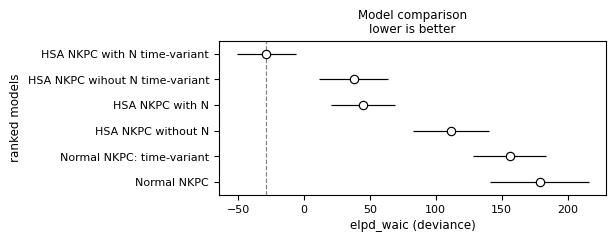

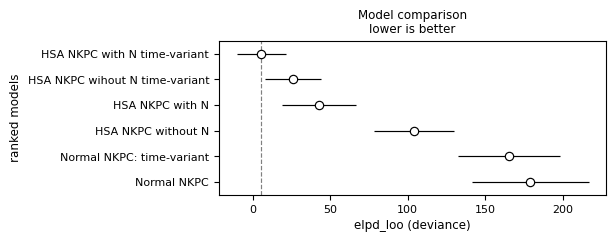

In [18]:
dict_idata = {'Normal NKPC':idata_1, 'Normal NKPC: time-variant':idata_6, 'HSA NKPC without N':idata_2,  'HSA NKPC with N':idata_3,'HSA NKPC wihout N time-variant':idata_4,'HSA NKPC with N time-variant':idata_5}
params = ["alpha","beta", "kappa", "theta_z", "theta_Y", "theta_pi", "theta_n", "rho_k", "rho_z", "rho_n", "sigma_eps", "sigma_kappa", "sigma_eta"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(5, 2))
display(summary_df)

cmp = az.compare(dict_idata, ic='waic', scale=None)  # ← deviance でなく純 elpd
display(cmp[['elpd_waic','p_waic']])
var = pd.DataFrame({
    "Variable": ["π", "Ŷ", "N", "E[πₜ₊₁]"],
    "Variance": [
        np.var(pi),
        np.var(Y),
        np.var(N),
        np.var(pi_expect)
    ]
})
display(var)

z_data = pd.DataFrame()
z_data["DATE"] = data["DATE"]
z_data["z_mean_2"] = z_mean_2
z_data["z_mean_3"] = z_mean_3
z_data["z_mean_4"] = z_mean_4
z_data["z_mean_5"] = z_mean_5

z_var = pd.DataFrame({
    "Model": ["Model 2", "Model 3", "Model 4", "Model 5"],
    "Variance of Z": [
        np.var(z_mean_2),
        np.var(z_mean_3),
        np.var(z_mean_4),
        np.var(z_mean_5)
    ]
})
display(z_var)



coeff = pd.DataFrame({
    "Variable": [
        "Cov(N, Y)"    
    ],
    "Correlation": [    
        np.corrcoef(data["N"], data["Y"])[0, 1]
    ]
})
display(coeff)


coeff_zY = pd.DataFrame({
    "Model": [
        "Model 2", "Model 3", "Model 4", "Model 5",
    ],
    "Cov(z, Y)": [    
        np.corrcoef(z_mean_2, data["Y"])[0, 1],
        np.corrcoef(z_mean_3, data["Y"])[0, 1], 
        np.corrcoef(z_mean_4, data["Y"])[0, 1],
        np.corrcoef(z_mean_5, data["Y"])[0, 1],
    ]
})
display(coeff_zY)

coeff_zN = pd.DataFrame({
    "Model": [
        "Model 2", "Model 3", "Model 4", "Model 5",
    ],
    "Cov(z, N)": [    
        np.corrcoef(z_mean_2, data["N"])[0, 1],
        np.corrcoef(z_mean_3, data["N"])[0, 1], 
        np.corrcoef(z_mean_4, data["N"])[0, 1],
        np.corrcoef(z_mean_5, data["N"])[0, 1],
    ]
})
display(coeff_zN)

df_loo_dev = az.compare(dict_idata, ic="loo", scale="deviance")
az.plot_compare(df_loo_dev, figsize=(5,2))
display(df_loo_dev)

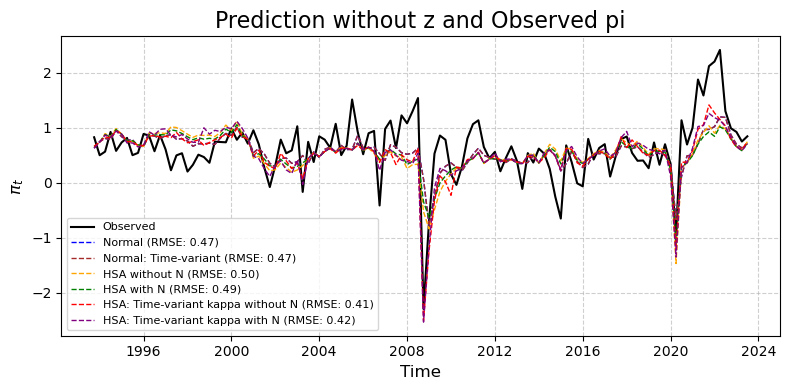

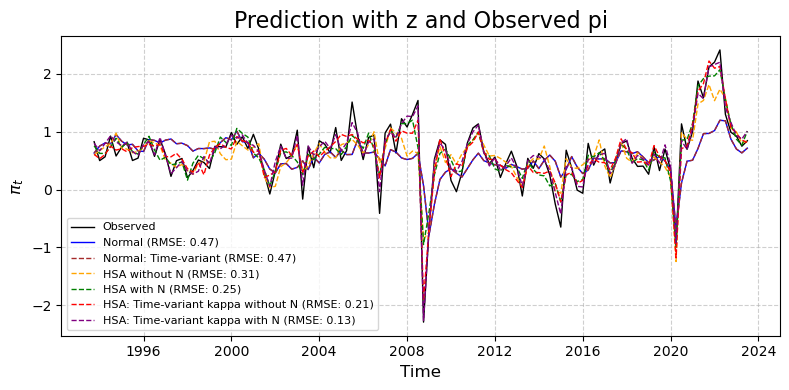

In [19]:
pi_pred_1 = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"]
pi_pred_2 = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"] 
pi_pred_3 = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"] 
pi_pred_4 = model_4_alpha * data["pi_prev"] + model_4_beta * data["Epi"] + kappa_mean_4 * data["Y"]
pi_pred_5 = model_5_alpha * data["pi_prev"] + model_5_beta * data["Epi"] + kappa_mean_5 * data["Y"]
pi_pred_6 = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"]

pi_pred_2_z = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"] - z_mean_2
pi_pred_3_z = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"] - z_mean_3
pi_pred_4_z = model_4_alpha * data["pi_prev"] + model_4_beta * data["Epi"] + kappa_mean_4 * data["Y"] - z_mean_4
pi_pred_5_z = model_5_alpha * data["pi_prev"] + model_5_beta * data["Epi"] + kappa_mean_5 * data["Y"] - z_mean_5

obs = data["pi"]

def get_scores(y_true, y_pred):
    e = y_true - y_pred
    rmse = np.sqrt(np.mean(e ** 2))
    mae = np.mean(np.abs(e))
    return rmse, mae

scores = {
    "Model 1": get_scores(obs, pi_pred_1),
    "Model 2": get_scores(obs, pi_pred_2),
    "Model 3": get_scores(obs, pi_pred_3),
    "Model 4": get_scores(obs, pi_pred_4),
    "Model 5": get_scores(obs, pi_pred_5),
    "Model 6": get_scores(obs, pi_pred_6),
}

# plot
title = "Prediction without z and Observed pi"
plt.figure(figsize=(8, 4))
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1.5)
plt.plot(data["DATE"], pi_pred_1, label=f"Normal (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[1], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_6, label=f"Normal: Time-variant (RMSE: {scores['Model 6'][0]:.2f})", 
         color=colors[6], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_2, label=f"HSA without N (RMSE: {scores['Model 2'][0]:.2f})", 
         color=colors[2], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_3, label=f"HSA with N (RMSE: {scores['Model 3'][0]:.2f})", 
         color=colors[3], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_4, label=f"HSA: Time-variant kappa without N (RMSE: {scores['Model 4'][0]:.2f})", 
         color=colors[4], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_5, label=f"HSA: Time-variant kappa with N (RMSE: {scores['Model 5'][0]:.2f})", 
         color=colors[5], linestyle='--', linewidth=1)
plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


scores = {
    "Model 1": get_scores(obs, pi_pred_1),
    "Model 2": get_scores(obs, pi_pred_2_z),
    "Model 3": get_scores(obs, pi_pred_3_z),
    "Model 4": get_scores(obs, pi_pred_4_z),
    "Model 5": get_scores(obs, pi_pred_5_z),
    "Model 6": get_scores(obs, pi_pred_6),
}

plt.figure(figsize=(8, 4))
title = "Prediction with z and Observed pi"
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_1, label=f"Normal (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[1], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_6, label=f"Normal: Time-variant (RMSE: {scores['Model 6'][0]:.2f})", 
         color=colors[6], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_2_z, label=f"HSA without N (RMSE: {scores['Model 2'][0]:.2f})", 
         color=colors[2], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_3_z, label=f"HSA with N (RMSE: {scores['Model 3'][0]:.2f})", 
         color=colors[3], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_4_z, label=f"HSA: Time-variant kappa without N (RMSE: {scores['Model 4'][0]:.2f})", 
         color=colors[4], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_5_z, label=f"HSA: Time-variant kappa with N (RMSE: {scores['Model 5'][0]:.2f})", 
         color=colors[5], linestyle='--', linewidth=1)

plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

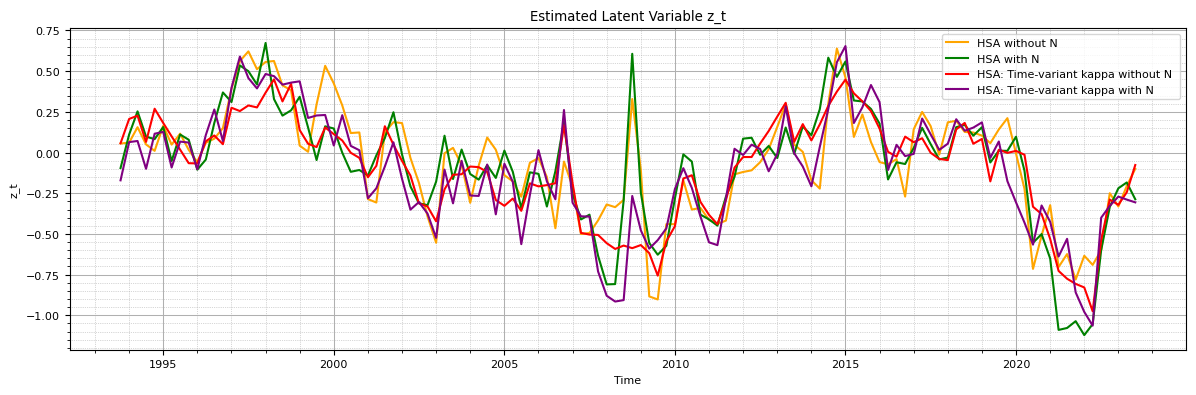

In [20]:
plt.rcParams.update({'font.size': 8}) 
import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_2, label="HSA without N", color=colors[2])
plt.plot(data["DATE"], z_mean_3, label="HSA with N ", color=colors[3])
plt.plot(data["DATE"], z_mean_4, label="HSA: Time-variant kappa without N ", color=colors[4])
plt.plot(data["DATE"], z_mean_5, label="HSA: Time-variant kappa with N", color=colors[5])
plt.title("Estimated Latent Variable z_t")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()


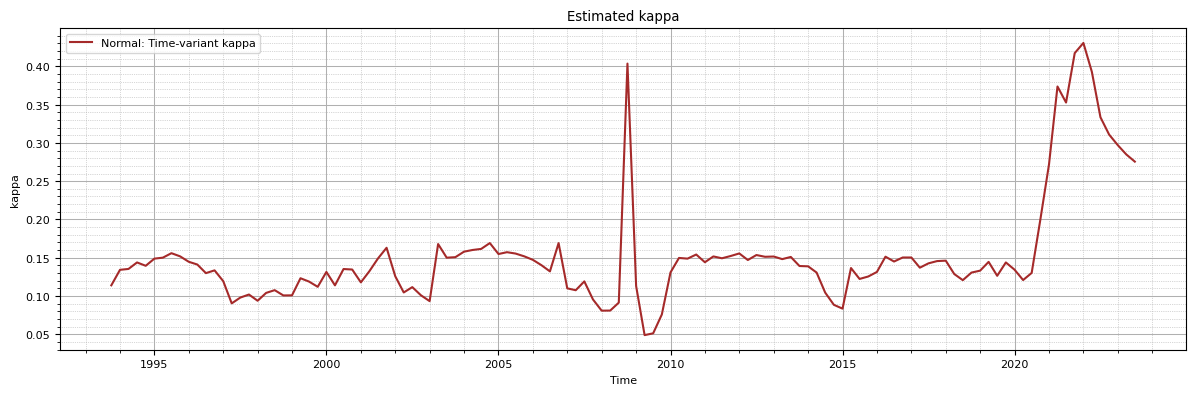

In [21]:
plt.rcParams.update({'font.size': 8}) 
import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_6, label="Normal: Time-variant kappa", color=colors[6])
# plt.fill_between(data["DATE"], kappa_lower_5, kappa_upper_5, color=colors[5], alpha=0.1, label="95% Credible Interval")
# plt.plot(data["DATE"], kappa_mean_4, label="HSA: Time-variant kappa without N ", color=colors[4])
# plt.fill_between(data["DATE"], kappa_lower_4, kappa_upper_4, color=colors[4], alpha=0.1, label="95% Credible Interval")
# plt.plot(data["DATE"], kappa_mean_5, label="HSA: Time-variant kappa with N", color=colors[5])
# plt.fill_between(data["DATE"], kappa_lower_5, kappa_upper_5, color=colors[5], alpha=0.1, label="95% Credible Interval")
plt.title("Estimated kappa")
plt.xlabel("Time")
plt.ylabel("kappa")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()
